# 2. Aprendizaje por refuerzo (Cuatro en raya)

#### Gutierrez Coronado Matias Ezequiel
#### Ingeniería de Sistemas
#### CU: 35-5558

# Definición del tablero y reglas de Cuatro en Raya

En este bloque defino la clase Board, que representa el tablero de Cuatro en Raya con 6 filas y 7 columnas. Aquí programo los métodos para identificar movimientos válidos, colocar fichas en la columna seleccionada y verificar si el juego ha terminado, ya sea por cuatro en línea (horizontal, vertical o diagonal) o por empate. También incluyo la función para reiniciar el tablero antes de cada partida.

In [1]:
import numpy as np

class Board():
    def __init__(self):
        self.rows = 6
        self.cols = 7
        self.state = np.zeros((self.rows, self.cols), dtype=int)

    def valid_moves(self):
        # Retorna las columnas donde todavía se puede jugar (al menos una casilla vacía arriba)
        return [col for col in range(self.cols) if 0 in self.state[:, col]]

    def update(self, symbol, col):
        # Coloca el símbolo en la fila más baja libre de la columna elegida
        for row in reversed(range(self.rows)):
            if self.state[row, col] == 0:
                self.state[row, col] = symbol
                return
        raise ValueError("¡Columna llena!")

    def is_game_over(self):
        # Verifica horizontal, vertical y diagonales para 4 en línea
        for row in range(self.rows):
            for col in range(self.cols):
                if self.state[row, col] == 0:
                    continue
                symbol = self.state[row, col]
                # Check horizontal
                if col <= self.cols - 4 and all(self.state[row, col + i] == symbol for i in range(4)):
                    return symbol
                # Check vertical
                if row <= self.rows - 4 and all(self.state[row + i, col] == symbol for i in range(4)):
                    return symbol
                # Check diagonal \
                if row <= self.rows - 4 and col <= self.cols - 4 and all(self.state[row + i, col + i] == symbol for i in range(4)):
                    return symbol
                # Check diagonal /
                if row <= self.rows - 4 and col >= 3 and all(self.state[row + i, col - i] == symbol for i in range(4)):
                    return symbol
        # Empate
        if not self.valid_moves():
            return 0
        # Seguir jugando
        return None

    def reset(self):
        self.state = np.zeros((self.rows, self.cols), dtype=int)


# Simulación de partidas automáticas y sistema de recompensas

En este bloque defino la clase Game, que se encarga de gestionar las partidas entre dos agentes para el entrenamiento. Uso el método selfplay para simular miles de juegos entre ambos, reiniciando el tablero en cada partida y alternando los turnos. Al finalizar cada juego, asigno recompensas: 1 punto al ganador, 0 al perdedor y 0.5 en caso de empate. Así, los agentes pueden aprender y mejorar su estrategia a lo largo de muchas partidas.

In [ ]:
from tqdm import tqdm

class Game():
    def __init__(self, player1, player2):
        player1.symbol = 1
        player2.symbol = -1
        self.players = [player1, player2]
        self.board = Board() 

    def selfplay(self, rounds=100):
        wins = [0, 0]
        for i in tqdm(range(1, rounds + 1)):
            self.board.reset()
            for player in self.players:
                player.reset()
            game_over = False
            while not game_over:
                for player in self.players:
                    col = player.move(self.board)  # ¡Solo columna!
                    self.board.update(player.symbol, col)  # Solo símbolo y columna
                    for p in self.players:
                        p.update(self.board)
                    if self.board.is_game_over() is not None:
                        game_over = True
                        break
            self.reward()
            for ix, player in enumerate(self.players):
                if self.board.is_game_over() == player.symbol:
                    wins[ix] += 1
        return wins

    def reward(self):
        winner = self.board.is_game_over()
        if winner == 0:  # empate
            for player in self.players:
                player.reward(0.5)
        else:  # gana alguien
            for player in self.players:
                if winner == player.symbol:
                    player.reward(1)
                else:
                    player.reward(0)


# Implementación del agente y su aprendizaje

En este bloque defino la clase Agent, que representa al jugador inteligente para Cuatro en Raya. Este agente utiliza una función de valor para evaluar los distintos estados del tablero y aprender a través de la experiencia. Decide su movimiento explorando (jugada aleatoria) o explotando (eligiendo la mejor columna según lo aprendido). Al terminar cada partida, el agente actualiza la función de valor de todos los estados que visitó, ajustando su estrategia poco a poco en base a la retroalimentación recibida.

In [4]:
class Agent():
    def __init__(self, alpha=0.5, prob_exp=0.5):
        self.value_function = {}  # tabla estado -> valor
        self.alpha = alpha
        self.positions = []       # estados visitados en la partida
        self.prob_exp = prob_exp  # probabilidad de explorar

    def reset(self):
        self.positions = []

    def move(self, board, explore=True):
        valid_moves = board.valid_moves()  # solo columnas disponibles
        # Exploración: columna aleatoria
        if explore and np.random.uniform(0, 1) < self.prob_exp:
            return np.random.choice(valid_moves)
        # Explotación: columna que genera el estado de mayor valor
        max_value = -1000
        best_col = valid_moves[0]
        for col in valid_moves:
            # simula el movimiento
            next_board = board.state.copy()
            # busca la fila más baja disponible en la columna
            for row in reversed(range(board.rows)):
                if next_board[row, col] == 0:
                    next_board[row, col] = self.symbol
                    break
            next_state = str(next_board.reshape(board.rows * board.cols))
            value = self.value_function.get(next_state, 0)
            if value >= max_value:
                max_value = value
                best_col = col
        return best_col

    def update(self, board):
        # Guarda el estado actual (como string)
        self.positions.append(str(board.state.reshape(board.rows * board.cols)))

    def reward(self, reward):
        # Al final de la partida, retropropaga el valor
        for p in reversed(self.positions):
            if self.value_function.get(p) is None:
                self.value_function[p] = 0
            self.value_function[p] += self.alpha * (reward - self.value_function[p])
            reward = self.value_function[p]


# Entrenamiento de los agentes

En este paso creo dos agentes y los enfrento en un gran número de partidas automáticas (200,000) para que puedan aprender la estrategia óptima jugando uno contra el otro. Durante este proceso, ambos agentes exploran y actualizan sus valores de cada estado, mejorando su toma de decisiones a medida que avanzan las partidas.

In [ ]:
agent1 = Agent(prob_exp=0.5)
agent2 = Agent()

game = Game(agent1, agent2)

game.selfplay(200000)

100%|██████████| 200000/200000 [1:16:52<00:00, 43.37it/s]


[117723, 81498]

# Visualización de la función de valor aprendida

En este bloque convierto la función de valor del agente en un DataFrame para analizar los estados del tablero que considera más valiosos después del entrenamiento. Ajusto las opciones de pandas para poder ver más filas y columnas en el output, facilitando así la revisión de los patrones y situaciones clave que el agente aprendió durante las partidas.

In [56]:
import pandas as pd

pd.set_option('display.max_rows', 100)    
pd.set_option('display.max_colwidth', 180)  

funcion_de_valor = sorted(agent1.value_function.items(), key=lambda kv: kv[1], reverse=True)
tabla = pd.DataFrame({'estado': [x[0] for x in funcion_de_valor], 'valor': [x[1] for x in funcion_de_valor]})

tabla


,estado,valor
0,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 -1 0 0 -1 0 0 -1 1 1 1 1],1.0
1,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 -1 -1 -1 1 1 1 1],1.0
2,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 -1 -1 0 -1 1 1 1 1],1.0
3,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 -1 0 1 1 1 1 -1 -1],1.0
4,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 -1 0 0 0 1 1 1 1 -1 0 -1],1.0
...,...,...
1983945,[ 0 0 0 0 0 0 -1 0 0 0 0 0 0 1 0 0 0 0 0 0 -1 1 -1 1\n 0 0 0 1 1 1 -1 0 -1 1 -1 1 -1 -1 -1 1 -1 1],0.0
1983946,[ 0 0 0 0 0 0 -1 0 0 0 0 0 0 1 0 0 0 0 0 0 -1 1 0 1\n 0 0 0 1 1 1 -1 0 -1 1 -1 1 -1 -1 -1 1 -1 1],0.0
1983947,[ 0 0 0 0 0 0 -1 0 0 0 0 0 0 1 0 0 0 0 0 0 -1 1 0 0\n 0 0 0 1 1 1 -1 0 -1 1 -1 1 -1 -1 -1 1 -1 1],0.0
1983948,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 -1 1 0 0\n 0 0 0 1 1 1 -1 0 -1 1 -1 1 -1 -1 -1 1 -1 1],0.0


# Visualización gráfica del tablero de Cuatro en Raya

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def plot_board(board_state):
    board_plot = np.flipud(board_state) 
    fig, ax = plt.subplots(figsize=(7, 6))
    # Dibuja casillas
    for x in range(board_plot.shape[1]):
        for y in range(board_plot.shape[0]):
            color = 'white'
            if board_plot[y, x] == 1:
                color = 'red'
            elif board_plot[y, x] == -1:
                color = 'yellow'
            circle = plt.Circle((x, y), 0.4, color=color, ec='black', lw=2)
            ax.add_artist(circle)
    # Ajustes de ejes
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-0.5, 5.5)
    ax.set_xticks(range(7))
    ax.set_yticks(range(6))
    ax.set_xticklabels(range(7))
    ax.set_yticklabels(range(5, -1, -1))
    ax.set_aspect('equal')
    plt.grid(which='both')
    plt.title("Cuatro en Raya")
    plt.show()


# Visualización dinámica de una partida entre agentes

In [58]:
def jugar_y_mostrar_grafico(game, agent1, agent2, delay=1.0):
    import time
    game.board.reset()
    agent1.reset()
    agent2.reset()
    players = [agent1, agent2]
    turno = 0
    plot_board(game.board.state)
    game_over = False
    while not game_over:
        player = players[turno % 2]
        col = player.move(game.board, explore=False)
        game.board.update(player.symbol, col)
        plot_board(game.board.state)
        time.sleep(delay)
        if game.board.is_game_over() is not None:
            game_over = True
        turno += 1
    ganador = game.board.is_game_over()
    if ganador == 0:
        print("¡Empate!")
    else:
        print(f"¡Gana el jugador {'Rojo' if ganador == 1 else 'Amarillo'}!")


# Ejecución y visualización de una partida real

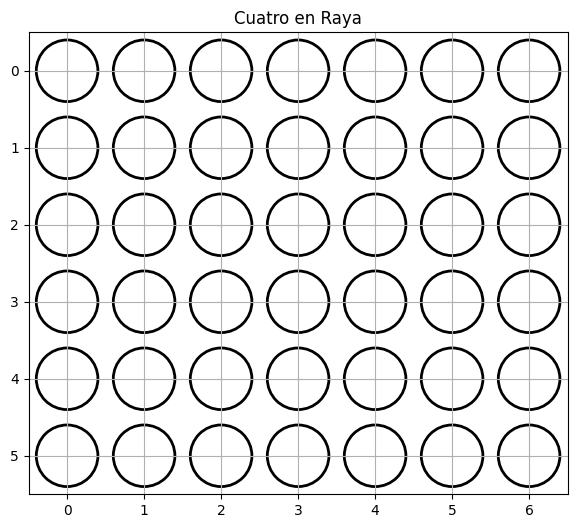

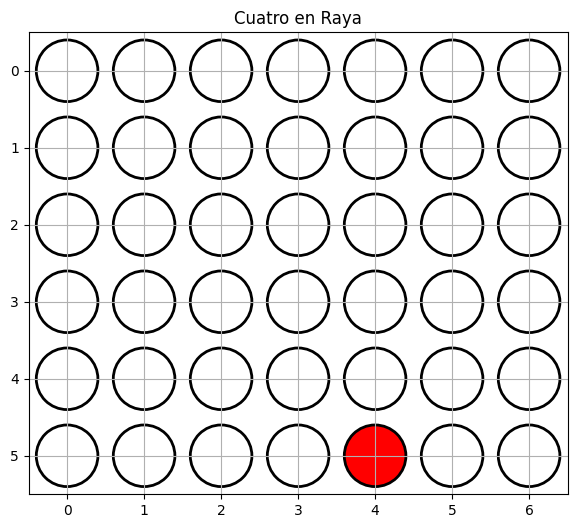

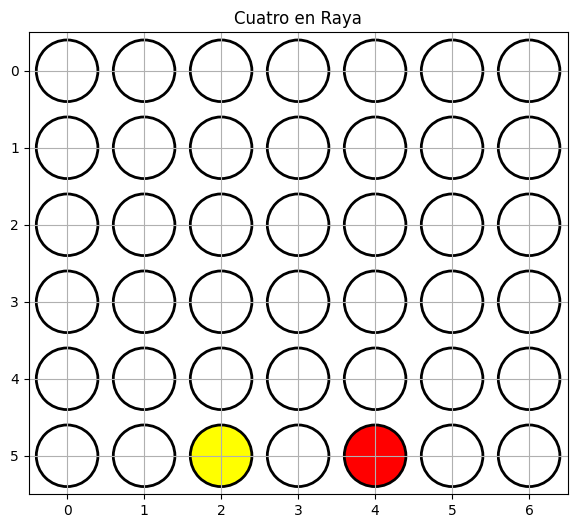

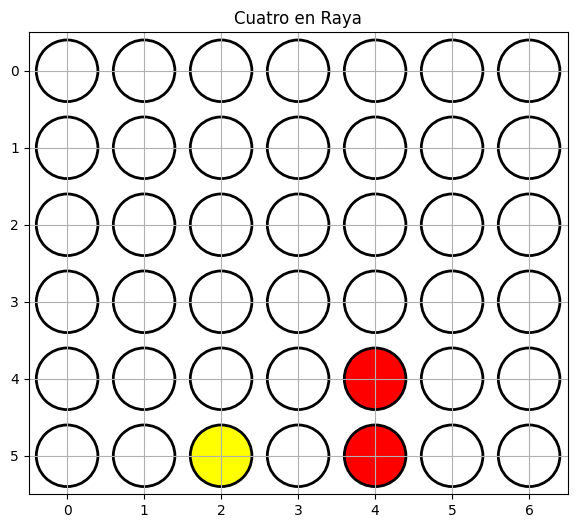

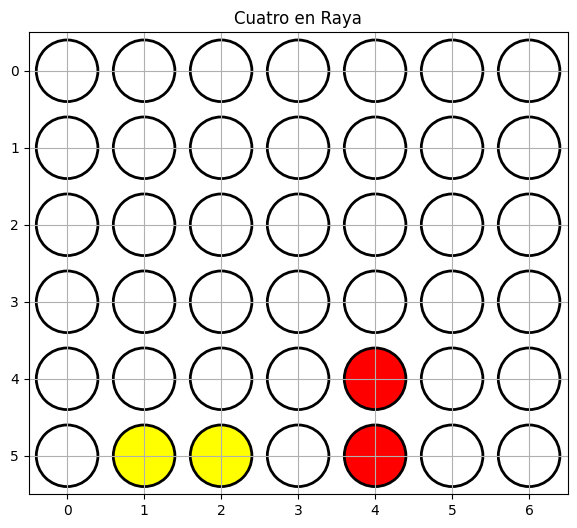

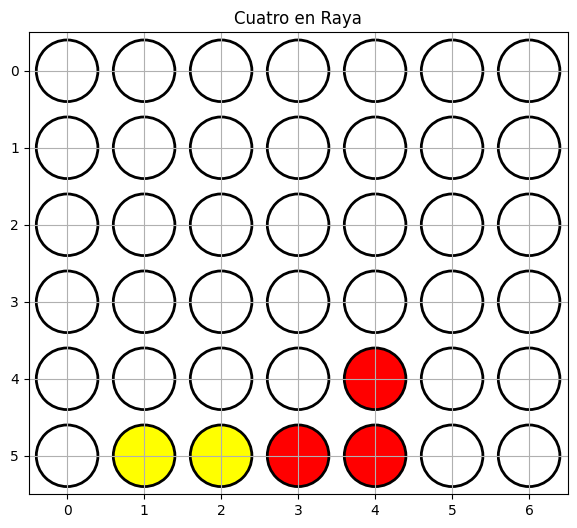

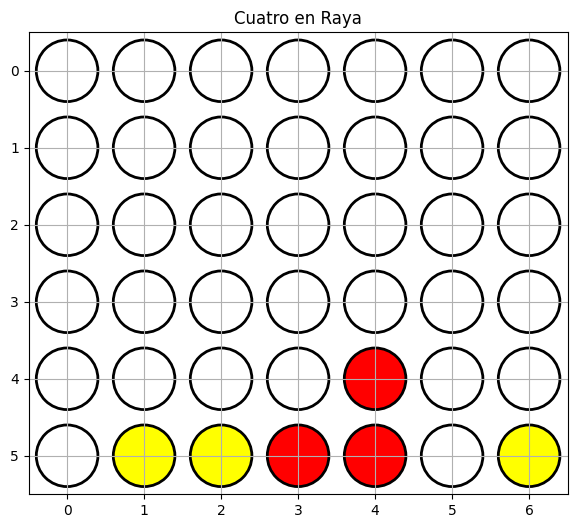

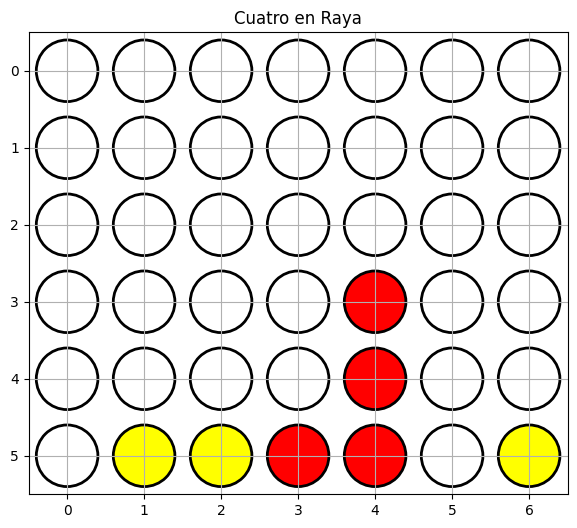

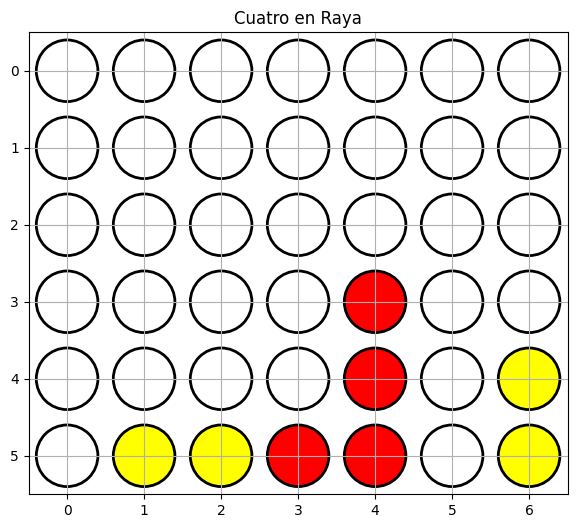

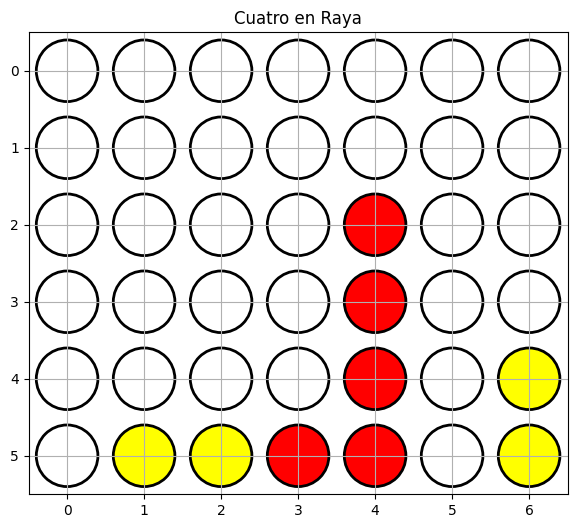

¡Gana el jugador Rojo!


In [59]:
jugar_y_mostrar_grafico(game, agent1, agent2, delay=0.8)
